In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/AI_Medical_project

ODIR-5K  Odir_sorted


In [ ]:
!pip install openpyxl


In [ ]:
import pandas as pd

excel_path = "/content/drive/MyDrive/AI_Medical_project/ODIR-5K/data.xlsx"
df = pd.read_excel(excel_path)

print(df.columns)

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:

excel_path = "/content/drive/MyDrive/AI_Medical_project/ODIR-5K/data.xlsx"
img_dir = "/content/drive/MyDrive/AI_Medical_project/ODIR-5K/Training Images"
output_dir = "/content/drive/MyDrive/AI_Medical_project/Odir_sorted"


In [ ]:
classes = ['normal', 'cataract', 'glaucoma', 'diabetic retinopathy']
splits = ['train', 'val', 'test']

# Create folders if not exist
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

In [ ]:
df = pd.read_excel(excel_path)
df['Labels'] = df['Left-Diagnostic Keywords'].fillna('') + ' ' + df['Right-Diagnostic Keywords'].fillna('')

def get_label(row):
    labels = str(row['Labels']).lower()
    for cls in classes:
        if cls in labels:
            return cls
    return None

df['filtered_label'] = df.apply(get_label, axis=1)
df = df[df['filtered_label'].notnull()]  # Keep only valid labels


In [ ]:
df = pd.read_excel(excel_path)
df['Labels'] = df['Left-Diagnostic Keywords'].fillna('') + ' ' + df['Right-Diagnostic Keywords'].fillna('')

def get_label(row):
    labels = str(row['Labels']).lower()
    for cls in classes:
        if cls in labels:
            return cls
    return None

df['filtered_label'] = df.apply(get_label, axis=1)
df = df[df['filtered_label'].notnull()]  # Keep only valid labels


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['filtered_label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['filtered_label'], random_state=42)


In [ ]:
def move_images(data, split):
    found = 0
    missing = 0
    for _, row in data.iterrows():
        image_id = str(row['ID'])
        label = row['filtered_label']

        left_img = os.path.join(img_dir, f"{image_id}_left.jpg")
        right_img = os.path.join(img_dir, f"{image_id}_right.jpg")

        if os.path.exists(left_img):
            shutil.copy(left_img, os.path.join(output_dir, split, label, f"{image_id}_left.jpg"))
            found += 1
        elif os.path.exists(right_img):
            shutil.copy(right_img, os.path.join(output_dir, split, label, f"{image_id}_right.jpg"))
            found += 1
        else:
            missing += 1

    print(f"✅ Copied {found} images to '{split}' | Missing: {missing}")

move_images(train_df, 'train')
move_images(val_df, 'val')
move_images(test_df, 'test')


✅ Copied 1491 images to 'train' | Missing: 0
✅ Copied 373 images to 'val' | Missing: 0
✅ Copied 467 images to 'test' | Missing: 0


In [ ]:
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}")
    for cls in classes:
        path = os.path.join(output_dir, split, cls)
        print(f"{cls}: {len(os.listdir(path))} images")



TRAIN
normal: 1255 images
cataract: 99 images
glaucoma: 106 images
diabetic retinopathy: 31 images

VAL
normal: 314 images
cataract: 25 images
glaucoma: 27 images
diabetic retinopathy: 7 images

TEST
normal: 393 images
cataract: 31 images
glaucoma: 34 images
diabetic retinopathy: 9 images


In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os


In [ ]:
base_dir = "/content/drive/MyDrive/AI_Medical_project/Odir_sorted"

img_height, img_width = 224, 224
batch_size = 32
num_classes = 4


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1491 images belonging to 4 classes.
Found 373 images belonging to 4 classes.
Found 467 images belonging to 4 classes.


In [ ]:
# Load base model (pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.8078 - loss: 0.7297 - val_accuracy: 0.8499 - val_loss: 0.4760
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8616 - loss: 0.4340 - val_accuracy: 0.8579 - val_loss: 0.4743
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8689 - loss: 0.4004 - val_accuracy: 0.8525 - val_loss: 0.4803
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8691 - loss: 0.3975 - val_accuracy: 0.8365 - val_loss: 0.5086
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.8778 - loss: 0.3630 - val_accuracy: 0.8365 - val_loss: 0.5126
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8712 - loss: 0.3705 - val_accuracy: 0.8391 - val_loss: 0.5091
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8697 - loss: 0.3681 - val_accuracy: 0.8660 - val_loss: 0.4920
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8648 - loss: 0.3905 - val_accuracy: 0.8231 - v

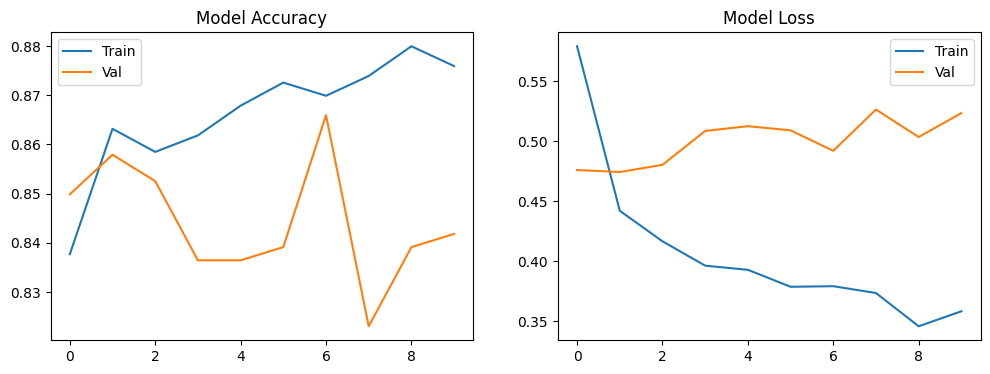

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Model Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Model Loss")
plt.legend()

plt.show()


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7413 - loss: 0.8149
✅ Test Accuracy: 85.65%


In [ ]:
!pip install opencv-python


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

inputs = tf.keras.Input(shape=(224, 224, 3))
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)


/tmp/ipython-input-97-1943105076.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)


In [ ]:
img_path = "/content/drive/MyDrive/AI_Medical_project/Odir_sorted/test/glaucoma/1241_left.jpg"

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

img_array = get_img_array(img_path)


In [ ]:
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("✅ Last Conv2D layer:", layer.name)
        break


✅ Last Conv2D layer: Conv_1


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv1", pred_index=None):
    conv_layer_output = model.get_layer(last_conv_layer_name).output
    grad_model = Model(inputs=model.input, outputs=[conv_layer_output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [ ]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Could not load image. Check path.")
        return

    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


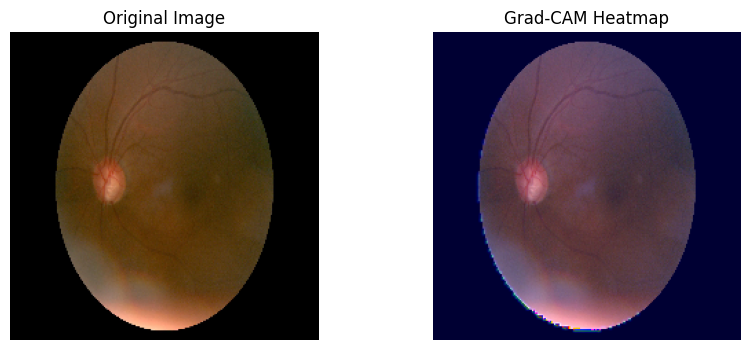

In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv1")
display_gradcam(img_path, heatmap)


In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00


In [ ]:
!pip install shap --quiet
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf


In [ ]:
img_path = "/content/drive/MyDrive/AI_Medical_project/Odir_sorted/test/glaucoma/1241_left.jpg"

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

img_array = get_img_array(img_path)


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_952
Received: inputs=['Tensor(shape=(32, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_952
Received: inputs=['Tensor(shape=(64, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_952
Received: inputs=['Tensor(shape=(64

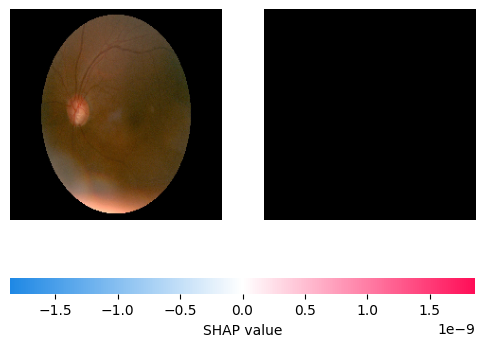

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Select one test image
img_path = "/content/drive/MyDrive/AI_Medical_project/Odir_sorted/test/glaucoma/1241_left.jpg"

def get_img_array(img_path, size=(224, 224)):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

img_array = get_img_array(img_path)

# Take 50 background images
background = next(train_generator)[0][:50]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Get SHAP values for the image
shap_values = explainer.shap_values(img_array)

# Plot SHAP heatmap
shap.image_plot(shap_values, img_array)
